In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
seed = 42
np.random.seed(seed=seed)
from statsmodels.tsa.stattools import kpss, adfuller
warnings.simplefilter("ignore")
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
train_df = pd.read_csv('/kaggle/input/playground-series-s5e1/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s5e1/test.csv')

In [3]:
train_df.shape

(230130, 6)

In [4]:
train_df.isna().sum(), test_df.isna().sum()

(id             0
 date           0
 country        0
 store          0
 product        0
 num_sold    8871
 dtype: int64,
 id         0
 date       0
 country    0
 store      0
 product    0
 dtype: int64)

In [5]:
train_df.isna().sum().sum() * 100 / train_df.shape[0]

3.854777734324078

Видим, что количество пропусков в процентном соотношении достаточно мало, поэтому можем удалить строчки, содержащие пропуски

In [6]:
train_df.dropna(inplace=True)

In [7]:
train_df.isna().sum(), train_df.shape

(id          0
 date        0
 country     0
 store       0
 product     0
 num_sold    0
 dtype: int64,
 (221259, 6))

In [8]:
train_df.head()

,id,date,country,store,product,num_sold
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0
5,5,2010-01-01,Canada,Stickers for Less,Holographic Goose,300.0


In [9]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()

In [10]:
train_df.date = enc.fit_transform(train_df.date)

In [11]:
train_df

,id,date,country,store,product,num_sold
1,1,0,Canada,Discount Stickers,Kaggle,973.0
2,2,0,Canada,Discount Stickers,Kaggle Tiers,906.0
3,3,0,Canada,Discount Stickers,Kerneler,423.0
4,4,0,Canada,Discount Stickers,Kerneler Dark Mode,491.0
5,5,0,Canada,Stickers for Less,Holographic Goose,300.0
...,...,...,...,...,...,...
230125,230125,2556,Singapore,Premium Sticker Mart,Holographic Goose,466.0
230126,230126,2556,Singapore,Premium Sticker Mart,Kaggle,2907.0
230127,230127,2556,Singapore,Premium Sticker Mart,Kaggle Tiers,2299.0
230128,230128,2556,Singapore,Premium Sticker Mart,Kerneler,1242.0


<Axes: xlabel='Count', ylabel='country'>

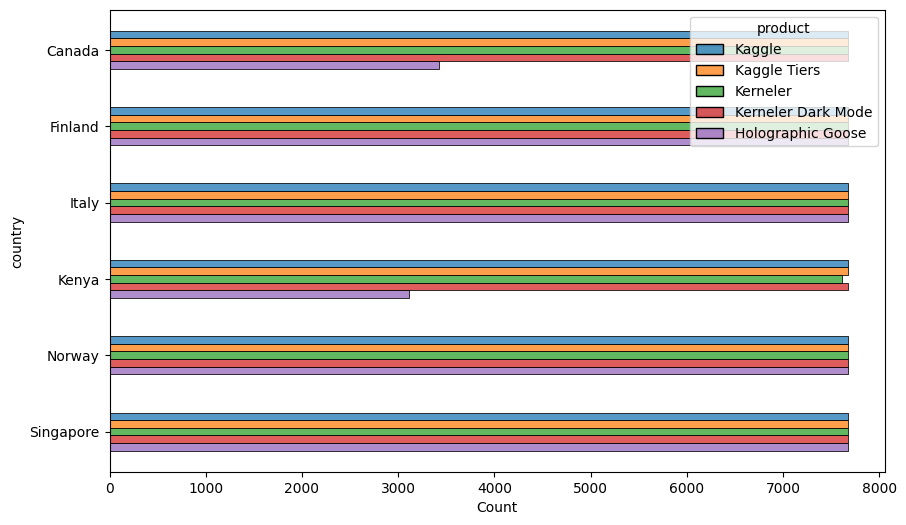

In [12]:
plt.figure(figsize=(10,6))
sns.histplot(data = train_df, y='country', hue='product', multiple='dodge', shrink=.5)

<Axes: xlabel='Count', ylabel='product'>

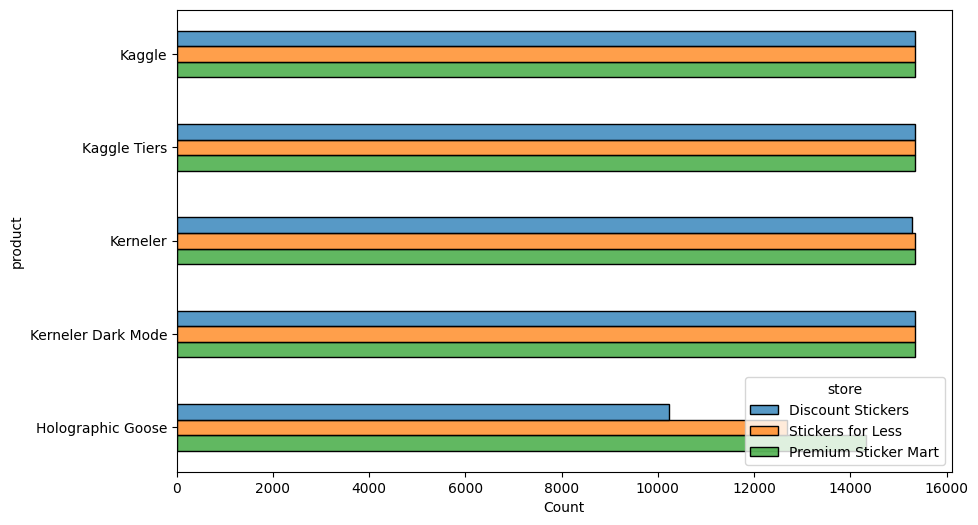

In [13]:
plt.figure(figsize=(10,6))
sns.histplot(data = train_df, y='product', hue='store', multiple='dodge', shrink=.5)

<Axes: xlabel='Count', ylabel='country'>

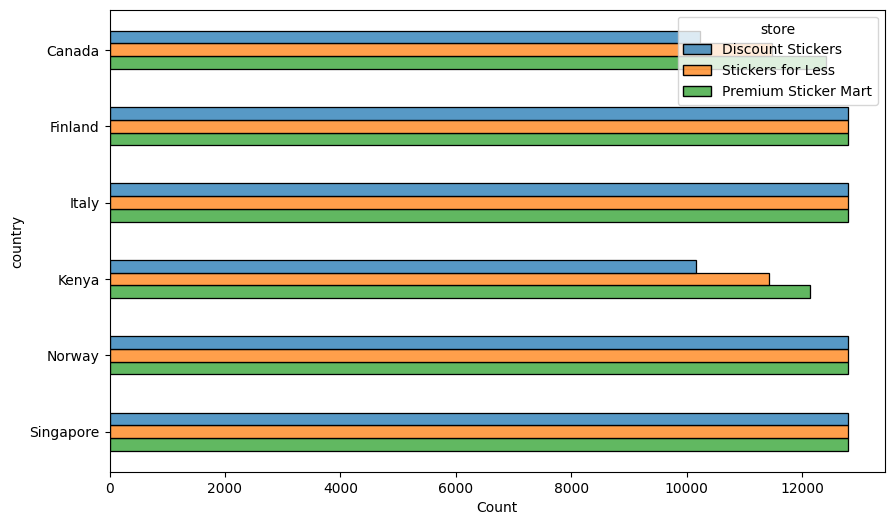

In [14]:
plt.figure(figsize=(10,6))
sns.histplot(data = train_df, y='country', hue='store', multiple='dodge', shrink=.5)

In [15]:
for_sarima_df = train_df.loc[:, ['date', 'num_sold']].groupby('date').agg('sum')

In [16]:
for_sarima_df

,num_sold
date,
0,85566.0
1,82548.0
2,88328.0
3,68075.0
4,65713.0
...,...
2552,64543.0
2553,71137.0
2554,77405.0


Воспользуемся несколькими подходами к прогнозированию временных рядов: Моделями ARIMA/SARIMA и методами машинного обучения

In [17]:
def create_train_valid(df):
    plt.figure(figsize=(10, 5))
    temp_train, temp_valid = train_test_split(df, test_size=0.2, shuffle=False)
    sns.lineplot(data=temp_train, x='date', y='num_sold')
    plt.xticks(rotation=90)
    plt.show()
    print(kpss(temp_train.num_sold)[1],\
                  adfuller(temp_train.num_sold)[1])
    return temp_train, temp_valid

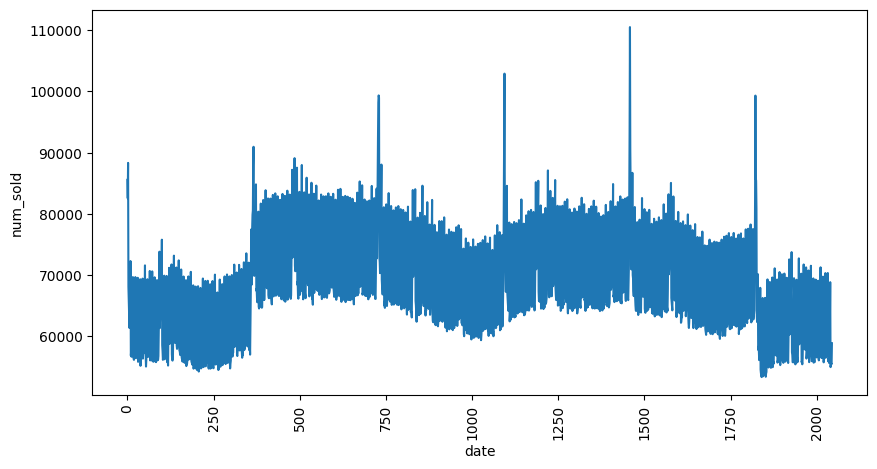

0.01 0.10190497510417951


In [18]:
train, valid = create_train_valid(for_sarima_df)

In [19]:
def find_d(df, d):
    fig, axes = plt.subplots(d, 1, sharex=True, figsize=(12, 12))
    for j in range(d):
        temp = df.copy()
        for k in range(1,j+1):
            temp.num_sold = temp.num_sold.diff()
            temp.dropna(axis = 0, inplace = True)
        plot_acf(temp.num_sold, ax=axes[j], title=f'd={j}')

In [20]:
def find_p(df, d):
    fig, axes = plt.subplots(1, 1, sharex=True, figsize=(10, 5))
    temp = df.copy()
    for k in range(1,d+1):
        temp.num_sold = temp.num_sold.diff()
        temp.dropna(axis = 0, inplace = True)
    axes.set(ylim=(-3,3))
    plot_pacf(temp.num_sold, ax=axes)
    plt.show()

In [21]:
def find_m(df, d):
    fig, axes = plt.subplots(1, 1, sharex=True, figsize=(10, 5))
    temp = df.copy()
    for k in range(1,d+1):
        temp.num_sold = temp.num_sold.diff()
        temp.dropna(axis = 0, inplace = True)
    axes.set(ylim=(-3,3))
    plot_acf(temp.num_sold, ax=axes)
    plt.show()

In [22]:
def find_s(df, s, d):
    fig, axes = plt.subplots(2, 1, sharex=True, figsize=(10, 5))
    temp = df.copy()
    for k in range(1,d+1):
        temp.num_sold = temp.num_sold.diff()
        temp.dropna(axis = 0, inplace = True)
        
    axes[0].plot(temp, label='Original Series')
    axes[1].plot(temp.diff(12), label='Seasonal Differencing', color='green')
    axes[1].set_title('Seasonal Differencing')

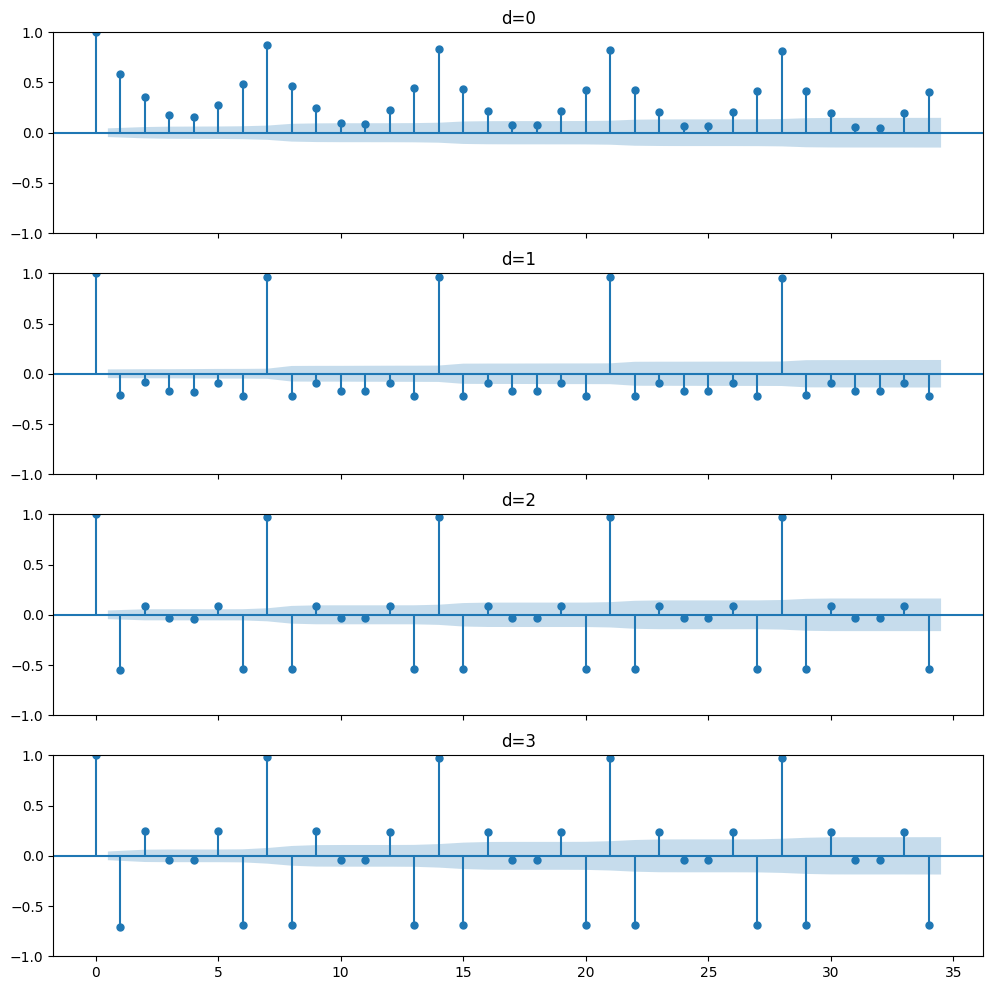

In [23]:
find_d(train, 4)

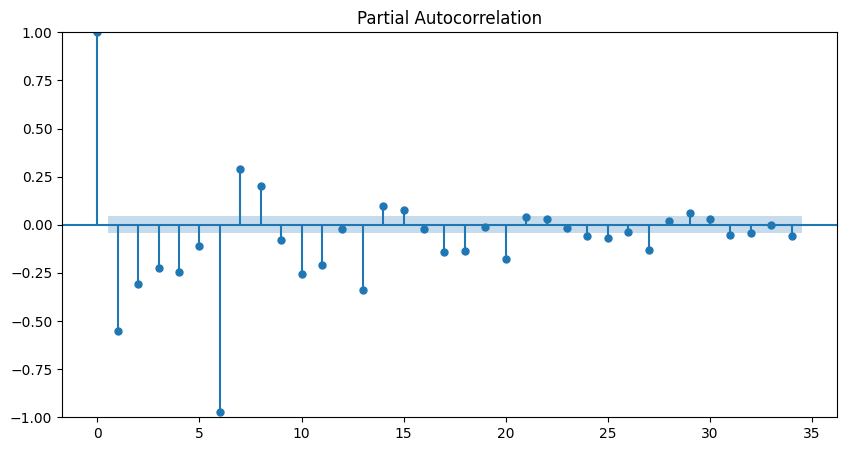

In [24]:
find_p(train, 2)

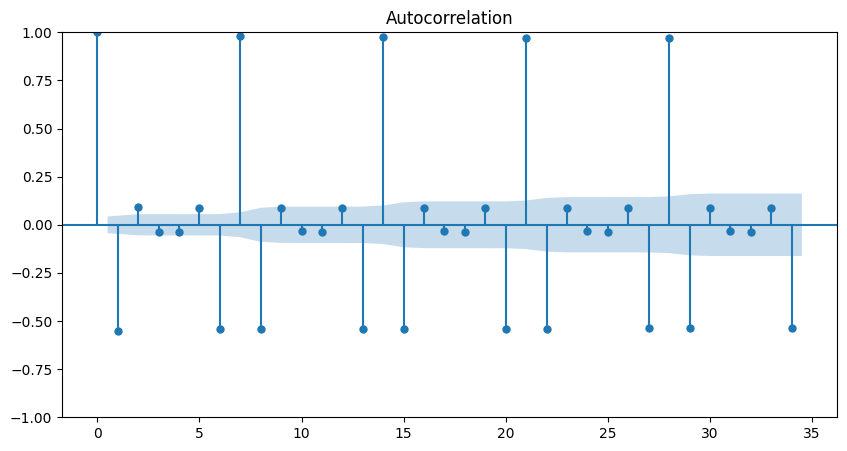

In [25]:
find_m(train, 2)

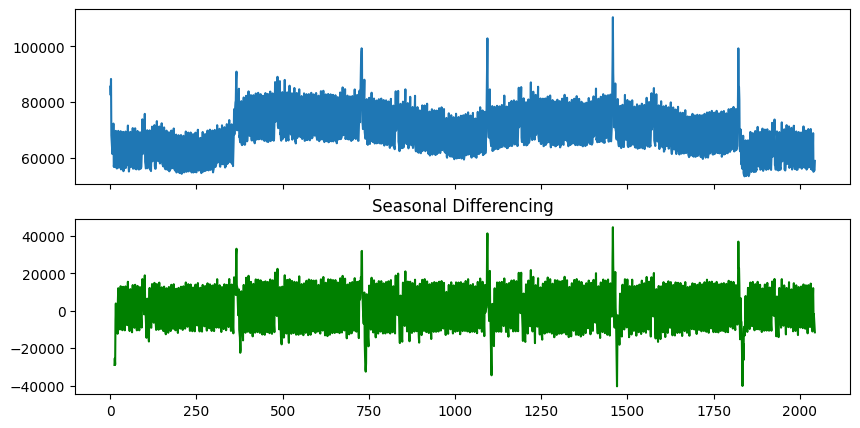

In [26]:
find_s(train, d=0, s=30)

In [27]:
model = SARIMAX(train.num_sold, seasonal_order = (6, 2, 1, 30), trend = 't')

In [28]:
model_fitted = model.fit()
print(model_fitted.summary())

                                      SARIMAX Results                                       
Dep. Variable:                             num_sold   No. Observations:                 2045
Model:             SARIMAX(1, 0, 0)x(6, 2, [1], 30)   Log Likelihood              -20979.913
Date:                              Fri, 10 Jan 2025   AIC                          41979.827
Time:                                      15:55:53   BIC                          42035.760
Sample:                                           0   HQIC                         42000.372
                                             - 2045                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0198      0.816      0.024      0.981      -1.579       1.618
ar.L1          0.90

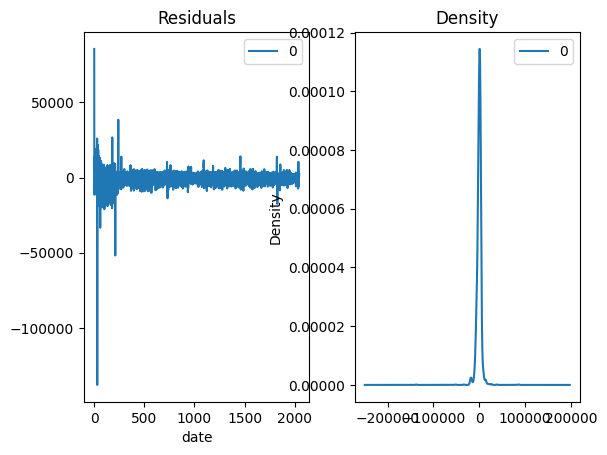

In [29]:
residuals = pd.DataFrame(model_fitted.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

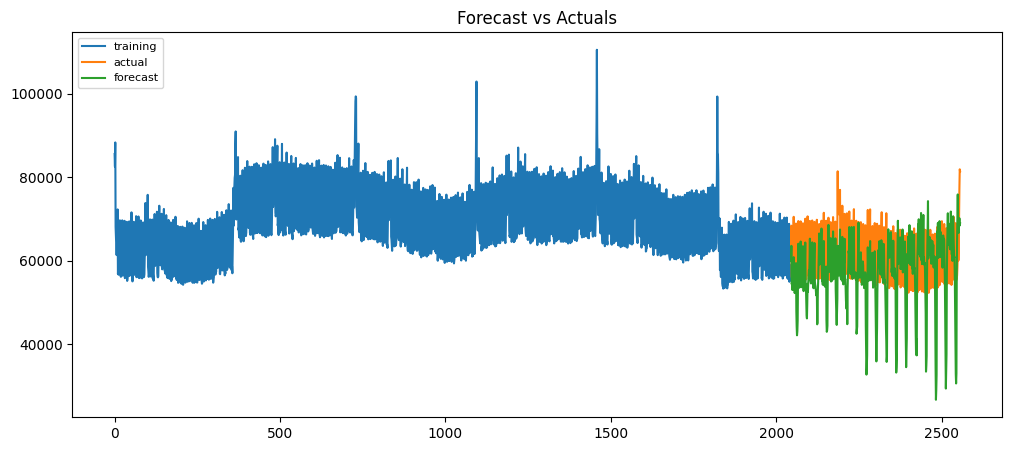

In [30]:
fc = model_fitted.forecast(steps=valid.shape[0], alpha=0.05)  # 95% conf

# Make as pandas series
# Plot
plt.figure(figsize=(12,5))
plt.plot(train, label='training')
plt.plot(valid, label='actual')
plt.plot(fc, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [31]:
fc

2045    60030.071800
2046    63568.967245
2047    54400.484126
2048    54843.036425
2049    52994.483086
            ...     
2552    66694.986051
2553    68797.862984
2554    70177.677876
2555    68451.225041
2556    68978.252301
Name: predicted_mean, Length: 512, dtype: float64

In [32]:
valid

,num_sold
date,
2045,62134.0
2046,68396.0
2047,56216.0
2048,55773.0
2049,57393.0
...,...
2552,64543.0
2553,71137.0
2554,77405.0


In [33]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse})

forecast_accuracy(fc, valid.num_sold)

{'mape': 0.10536492588463435,
 'me': -1998.4913835817968,
 'mae': 6220.708536658853,
 'mpe': -0.029443416914016272,
 'rmse': 8653.163119770594}